In [1]:
import cobra
from cobra import Model, Reaction, Metabolite
from cobra.test import create_test_model

In [2]:
import cplex

In [3]:
import numpy as np
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from cobra.test import create_test_model
model = create_test_model('textbook')

In [53]:
model.exchanges.EX_o2_e

Reaction identifier,EX_o2_e
Name,O2 exchange
Memory address,0x07f4254c1d880
Stoichiometry,o2_e <=> O2 <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [54]:
model.exchanges.EX_glc__D_e

Reaction identifier,EX_glc__D_e
Name,D-Glucose exchange
Memory address,0x07f4254c16f10
Stoichiometry,glc__D_e <=> D-Glucose <=>
GPR,
Lower bound,-10.0
Upper bound,1000.0


In [5]:
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose, O2, Acetate  = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import
    model.reactions.EX_o2_e.lower_bound= -15.0 * (O2 / (0.024 + O2))
    model.reactions.EX_ac_e.lower_bound= 10.0 * (Acetate / (2 + Acetate))

def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose, O2, Acetate  = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['Biomass_Ecoli_core', 'EX_glc__D_e', 'EX_o2_e', 'EX_ac_e'], ['max', 'max', 'max', 'max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [6]:
ts = np.linspace(0, 15, 100)  # Desired integration resolution and interval
y0 = [0.1, 10, 0.24, 0]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

t = 0.666: : 388it [01:22,  4.73it/s]


In [7]:
sol

  message: 'A termination event occurred.'
     nfev: 376
     njev: 2
      nlu: 28
      sol: None
   status: 1
  success: True
        t: array([0.        , 0.15151515, 0.3030303 , 0.45454545])
 t_events: [array([0.54092146])]
        y: array([[1.00000000e-01, 1.07961801e-01, 1.11323835e-01, 1.13165243e-01],
       [1.00000000e+01, 9.89509886e+00, 9.78446758e+00, 9.67213673e+00],
       [2.40000000e-01, 4.41762515e-02, 8.23982143e-06, 2.24595375e-09],
       [0.00000000e+00, 4.27800178e-02, 1.55706011e-01, 2.55026716e-01]])
 y_events: [array([[ 1.14222253e-01,  9.60747306e+00, -1.59999989e-09,
         3.12217545e-01]])]

Text(0, 0.5, 'Acetate')

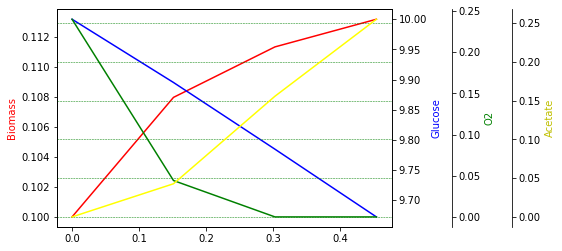

In [8]:
#ax = plt.subplot(111)
#ax.plot(sol.t, sol.y.T[:, 0])
#ax2 = plt.twinx(ax)
#ax2.plot(sol.t, sol.y.T[:, 1], color='r')
#ax3 = plt.twinx(ax)
#ax3.plot(sol.t, sol.y.T[:, 2], color='g')



ig, ax1 = plt.subplots()

ax1.plot(sol.t, sol.y.T[:, 0], color='r')
ax2 = plt.twinx(ax1)
ax2.plot(sol.t, sol.y.T[:, 1], color='b')

ax3 = ax1.twinx()
ax3.plot(sol.t, sol.y.T[:, 2],color="green")
ax3.spines['right'].set_position(('outward',60))

ax4 = ax1.twinx()
ax4.plot(sol.t, sol.y.T[:, 3],color="yellow")
ax4.spines['right'].set_position(('outward',120))

plt.grid(axis = 'both', color = 'green', linestyle = '--', linewidth = 0.5)

ax1.set_ylabel('Biomass', color='r')
ax2.set_ylabel('Glucose', color='b')
ax3.set_ylabel('O2', color='g')
ax4.set_ylabel('Acetate', color='y')

In [27]:
help (cobra.util.add_lexicographic_constraints)

Help on function add_lexicographic_constraints in module cobra.util.solver:

add_lexicographic_constraints(model: 'Model', objectives: List[ForwardRef('Reaction')], objective_direction: Union[str, List[str]] = 'max') -> pandas.core.series.Series
    Successively optimize separate targets in a specific order.
    
    For each objective, optimize the model and set the optimal value as a
    constraint. Proceed in the order of the objectives given. Due to the
    specific order this is called lexicographic FBA [1]_. This procedure
    is useful for returning unique solutions for a set of important
    fluxes. Typically this is applied to exchange fluxes.
    
    Parameters
    ----------
    model : cobra.Model
        The model to be optimized.
    objectives : list of cobra.Reaction
        A list of reactions (or objectives) in the model for which unique
        fluxes are to be determined.
    objective_direction : str or list of str, optional
        The desired objective direction